# Feature Engineering

Will be extended soon. 

## Data Leakage in Train–Test Splits

### What is data leakage?

**Data leakage** occurs when information from the **test set** or from the **future** is used—directly or indirectly—during model training. As a result, model performance appears much better than it truly is and fails to generalize to real‑world data.

> **Rule of thumb:** if the model has access to information during training that would not be available at prediction time, there is data leakage.

---

### Why is data leakage a problem?

The purpose of a train–test split is to simulate unseen future data. When leakage occurs:

- Test data is no longer independent
- Evaluation metrics (accuracy, RMSE, MAPE, …) become overly optimistic
- Model comparison becomes invalid
- Deployed models often perform poorly

---

### Common types of data leakage

#### 1. Leakage through preprocessing

**Wrong approach:**
- Scaling, imputing, or encoding using the **entire dataset** before splitting

**Correct approach:**
- Split the data first
- Fit preprocessing steps **only on training data**
- Apply the learned transformations to both train and test data

✅ Best practice: use machine‑learning **pipelines**.

---

#### 2. Target leakage

Target leakage happens when features contain information that is a direct or indirect consequence of the target variable.

**Example (kijkcijfers):**
- Predicting tomorrow’s viewers
- Using features such as daily ranking, total daily viewers, or advertising revenue

❌ These values are only known after broadcast
✅ They must not be used for prediction

---

#### 3. Time‑based leakage

Common in forecasting problems.

**Wrong:** random train–test split across time

**Correct:** chronological split

- Train: past data
- Test: future data

> Always respect the arrow of time.

---

#### 4. Leakage via feature engineering

Leakage can occur when engineered features use future information.

**Example:**
- Using season‑wide averages to predict early episodes

✅ Use rolling or expanding statistics limited to past data only.

---

#### 5. Leakage via duplication or grouping

Occurs when similar or related observations appear in both train and test sets.

**Example:**
- Different episodes of the same TV show in train and test

✅ Use group‑based splitting (e.g. by program or show).

---

### How to detect data leakage

Ask yourself:

1. Is this feature available at prediction time?
2. Does preprocessing use test‑set statistics?
3. Am I using future information?
4. Are the results suspiciously good?

🚩 Extremely high performance is often a warning sign.

---

### How to prevent data leakage

- Split data **before** preprocessing
- Use pipelines for transformations
- Avoid random splits for time‑dependent data
- Carefully justify every feature
- Document assumptions about data availability

---

### One‑sentence definition

> **Data leakage occurs when information that would not be available at prediction time is used during training or evaluation, leading to overly optimistic performance estimates.**

## Encoding techniques

### Ordinal encoding
See [End to end machine learning project notebook](./210-end_to_end_machine_learning_project.ipynb) for more details.

### One-hot encoding
See [End to end machine learning project notebook](./210-end_to_end_machine_learning_project.ipynb) for more details.

### Target encoding (for high cardinality)
Target Encoding (also known as Mean Encoding or Likelihood encoding or Effect encoding) is used when a categorical feature has many unique values (e.g., Zip Codes, City names, or Product IDs). One-Hot Encoding these would create thousands of columns, leading to the "curse of dimensionality".  
Each category is replaced by the average value of the target variable ($y$) (!!!! Yes, y!!!!) for that category. To counteract overfitting (especially for categories with very few samples, prevention is impossible, as you use a transformed y values to x values!!!), we use smoothing to blend the category average with the global average. The formula for the encoded value is:

$$\hat{x}_i = w_i \cdot \mu_i + (1 - w_i) \cdot \mu_{global}$$

where:
- $\mu_i$: The average of that specific category $i$
- $\mu_{global}$: The global average of the dataset
- $w_i$: A weight (between 0 and 1) that is larger when you have more observations for that category

An example:

In [24]:
from sklearn.preprocessing import TargetEncoder
import pandas as pd
import numpy as np

# Sample data: Increased counts to satisfy 5-fold CV
data = {
    'city': ['Brussels'] * 50 + ['Ghent'] * 50 + ['Antwerp'] * 50 + ['Liège'] * 50 + ['Charleroi'] * 50,
    'price': np.random.normal(350000, 50000, 250)
}
df = pd.DataFrame(data)

X = df[['city']]
y = df['price']

# cv=5 is default; shuffle=False for reproducibility in examples
target_enc = TargetEncoder(target_type='continuous', random_state=42)

# Fit and encode
X_encoded = target_enc.fit_transform(X, y)

print("Mapping of Cities to Encoded Values:")
# We can view the learned mean for each category (the 'infomation' used for encoding)
categories = target_enc.categories_[0]
# TargetEncoder stores the smoothed means in encodings_[0]
for city, val in zip(categories, target_enc.encodings_[0]):
    print(f"{city:10} -> {val:,.0f}")

Mapping of Cities to Encoded Values:
Antwerp    -> 347,215
Brussels   -> 355,458
Charleroi  -> 352,650
Ghent      -> 355,654
Liège      -> 358,298


### Cycling encoding (for Periodic Data)
Linear models, neural networks and models in general, struggle with time-based features. They don't have any notion that hour 23 and hour 0 are only 1 hour apart, they see them as 23 units apart.  
We project the cyclical feature onto a circle by creating two new features using sine and cosine transformations. For a variable $x$ with a period $L$ (e.g., $L=24$ for hours):

$$ x_{sin} = \sin\left(\frac{2 \cdot \pi \cdot x}{L}\right)$$
$$x_{cos} = \cos\left(\frac{2 \cdot \pi \cdot x}{L}\right) $$

An example: (Can you figure out why both sine and cosine have been used?)

Cyclical Encoding Table:
   hour  hour_sin  hour_cos
0     0  0.000000  1.000000
1     1  0.258819  0.965926
2     2  0.500000  0.866025
3     3  0.707107  0.707107
4     4  0.866025  0.500000


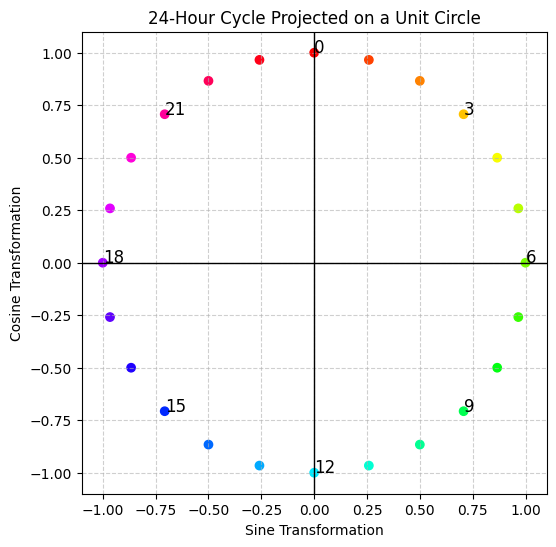

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Create a dummy dataset (24 hours)
df = pd.DataFrame({'hour': np.arange(24)})

# 2. Define the period (L)
L = 24

# 3. Apply Sine and Cosine transformations
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / L)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / L)

# Display the first few rows
print("Cyclical Encoding Table:")
print(df.head())

# 4. Visualize the result
plt.figure(figsize=(6,6))
plt.scatter(df['hour_sin'], df['hour_cos'], c=df['hour'], cmap='hsv')
plt.title("24-Hour Cycle Projected on a Unit Circle")
plt.xlabel("Sine Transformation")
plt.ylabel("Cosine Transformation")
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.grid(True, linestyle='--', alpha=0.6)

# Label a few hours for clarity
for i, txt in enumerate(df['hour']):
    if i % 3 == 0: # Label every 3 hours
        plt.annotate(txt, (df['hour_sin'][i], df['hour_cos'][i]), fontsize=12)

plt.show()

## Some other feature Engineering techniques
###  Lag features

Pay attention for data leakage!

### Using LLM's to generate extra features

